<a href="https://colab.research.google.com/github/elifftosunn/RFM-Customers-Analysis/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/RFM/datas/OnlineRetail.csv",encoding= 'unicode_escape')
df.head()

In [ ]:
df.info()

In [ ]:
df.drop(["CustomerID"], axis = 1).describe()

In [ ]:
df.shape, df.duplicated().sum()

In [ ]:
# remove duplicate values from dataset
df = df.drop_duplicates()
df.shape

In [ ]:
df.isnull().sum().sort_values(ascending=False)

In [ ]:
# remove NaN values from dataset
df = df.dropna(subset=['CustomerID'])
df.shape

In [ ]:
df.isnull().sum().sort_values(ascending=False)

In [ ]:
# convert datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [ ]:
# remove Quantity and UnitPrice negative values from dataset
df = df.loc[df.Quantity > 0]
df = df.loc[df.UnitPrice > 0]
df.shape

In [ ]:
# calculate total price
df["Revenue"] = df["Quantity"]*df["UnitPrice"]

In [ ]:
df["Year"] = df.InvoiceDate.apply(lambda x: x.year)
df["Month"] = df.InvoiceDate.apply(lambda x: x.month)
df["Day"] = df.InvoiceDate.apply(lambda x: x.day)

In [ ]:
#creating Year-Month field for the ease of reporting and visualization
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: str(date.year)+"-" +str(date.month))

In [ ]:
plt.figure(figsize = (25,8))
sns.lineplot(data=df, x="InvoiceYearMonth", y="Revenue")
plt.title("Monthly Revenue", fontsize = 20)
plt.show()

In [ ]:
# using pct_change() function to see monthly percentage change
df['MonthlyGrowth'] = df['Revenue'].pct_change()
df.MonthlyGrowth

In [ ]:
df.to_csv("/content/drive/MyDrive/RFM/datas/fe_retail_data.csv", index=False)

In [ ]:
plt.figure(figsize = (25,8))
sns.lineplot(data=df, x="Month", y="MonthlyGrowth")
plt.title("Montly Growth Rate", fontsize = 20)
plt.show()

# ONLY UK CUSTOMERS

In [ ]:
df.loc[df.Country == "United Kingdom"].CustomerID.nunique()/df.CustomerID.nunique()

**90% of the data consists of UK**

In [ ]:
# Creating a new dataframe with UK customers only
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)
df_uk

In [ ]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_uk_monthly_active = df_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

plt.figure(figsize = (25,8))
sns.barplot(data = df_uk_monthly_active, x = "InvoiceYearMonth", y = "CustomerID")
plt.title("plt Dataframe", fontsize = 14)
plt.show()

In [ ]:
df_uk_monthly_active = df_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()
df_uk_monthly_active.to_csv("/content/drive/MyDrive/RFM/datas/df_uk_monthly_active.csv", index = False)

**In the 11th month of 2011, there are the highest number of unique customers. So there are 1505 unique customers.**

In [ ]:
df_uk_monthly_active.sort_values("CustomerID", ascending=False)

In [ ]:
# calculate total Quantity by month then visualization
sumQuantityByMonth = df_uk.groupby("InvoiceYearMonth")["Quantity"].sum().reset_index()

plt.figure(figsize = (25,8))
sns.barplot(data = sumQuantityByMonth, x = "InvoiceYearMonth", y = "Quantity")
plt.title("Monthly Total of Order", fontsize = 14)
plt.show()

In [ ]:
# create a new dataframe for average revenue by taking the mean of it
df_uk.groupby("InvoiceYearMonth")["Revenue"].mean().reset_index()

In [ ]:
meanRevenueByMonth = df_uk.groupby("Month")["Revenue"].mean().reset_index()
plt.figure(figsize = (25,8))
sns.barplot(data = meanRevenueByMonth, x = "Month", y = "Revenue")
plt.title("Monthly Mean of Revenue", fontsize = 14)
plt.show()

In [ ]:
# Create a dataframe contaning CustomerID and first purchase order date
df_min_purchase_order = df_uk.groupby("CustomerID").InvoiceDate.min().reset_index()
df_min_purchase_order.columns = ['CustomerID','MinPurchaseOrderDate']
df_min_purchase_order["MinPurchaseOrderYearMonth"] = df_min_purchase_order["MinPurchaseOrderDate"].map(lambda x: str(x.year)+"-"+str(x.month))
# Merge first purchase date column to our main dataframe (df_uk)
df_uk = pd.merge(df_uk, df_min_purchase_order, on='CustomerID')
df_uk.head()

In [ ]:
# Existing Customer or New Customer?
df_uk['UserType'] = 'New'
df_uk.loc[df_uk['InvoiceYearMonth']>df_uk['MinPurchaseOrderYearMonth'],'UserType'] = "Existing"
df_uk_user_type_revenue = df_uk.groupby(['InvoiceYearMonth','MinPurchaseOrderYearMonth','UserType'])['Revenue'].sum().reset_index()
df_uk_user_type_revenue

In [ ]:
existingCustomerDf = df_uk_user_type_revenue.loc[df_uk_user_type_revenue.UserType == "Existing"]
newCustomerDf = df_uk_user_type_revenue.loc[df_uk_user_type_revenue.UserType == "New"]
plt.figure(figsize = (25,8), dpi=80)
sns.lineplot(data = newCustomerDf.query("InvoiceYearMonth != '2010-12' and InvoiceYearMonth != '2011-12'"),
         x = "InvoiceYearMonth",
         y = "Revenue",
         color = "black", label = "New")
sns.lineplot(data = existingCustomerDf.query("InvoiceYearMonth != '2010-12' and InvoiceYearMonth != '2011-12'"),
         x = "InvoiceYearMonth",
         y = "Revenue",
         color = "red", label = "Existing")
plt.title("New Customer or Existing Customer")
plt.legend()
plt.show()

In [ ]:
df_uk_user_ratio = df_uk.query("UserType == 'New'").groupby(["InvoiceYearMonth"])["CustomerID"].nunique()/df_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
df_uk_user_ratio = df_uk_user_ratio.reset_index()
df_uk_user_ratio = df_uk_user_ratio.dropna()
df_uk_user_ratio

In [ ]:
plt.figure(figsize=(15,6), dpi = 80)
sns.barplot(data = df_uk_user_ratio.query("InvoiceYearMonth > '2011-11'").sort_values("InvoiceYearMonth", ascending=True),
            x = "InvoiceYearMonth",
            y = "CustomerID")
plt.title("New Customer Ratio of UK")
plt.show()

**The rate of new customers in the UK decreased from month to month**

In [ ]:
# Users(CustomerID) who are active by looking at their monthly revenue
df_user_purchase_order = df_uk.groupby(["CustomerID", "InvoiceYearMonth"])["Revenue"].sum().reset_index()
df_user_purchase_order

In [ ]:
plt.figure(figsize = (25,6), dpi=80)
sns.barplot(data = df_uk.groupby(["CustomerID"])["Revenue"].sum().reset_index().sort_values("Revenue", ascending=False).head(20),
            x = "CustomerID", y = "Revenue")
plt.title("Top 20 Customers with Highest Revenue by Customer ID")
plt.show()

# RFM(Recency, Frequency, Monetary) Analysis

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/RFM/datas/OnlineRetail.csv",encoding= 'unicode_escape')
df = df.drop_duplicates()
df = df.dropna(subset=['CustomerID'])
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.loc[df.Quantity > 0]
df = df.loc[df.UnitPrice > 0]
df["Revenue"] = df["Quantity"]*df["UnitPrice"]
df.head()

In [ ]:
max_date = df.InvoiceDate.max()
max_date

In [ ]:
now = dt.datetime(2011,12,10)

In [ ]:
now.day

In [ ]:
rfmTable = df.groupby("CustomerID").agg({"InvoiceDate":lambda x: (now - x.max()).days, 
                              "Revenue": lambda x: x.sum(),
                              "InvoiceNo": lambda x: len(x)})
rfmTable["InvoiceDate"] = rfmTable["InvoiceDate"].astype(int)
rfmTable.rename(columns = {"InvoiceDate":"Recency",
                           "Revenue":"Monetary",
                           "InvoiceNo":"Frequency"}, inplace = True)
rfmTable

In [ ]:
rfmTable.sort_values("Monetary", ascending=False)

In [ ]:
quantiles = rfmTable.quantile(q = [0.2,0.4,0.6, 0.8])
quantiles = quantiles.to_dict()
quantiles

In [ ]:
def RScore(x, p, d):
  if x <= d[p][0.2]:
    return 5
  elif x <= d[p][0.4]:
    return 4
  elif x <= d[p][0.6]:
    return 3
  elif x <= d[p][0.8]:
    return 2
  else:
    return 1
def FScore(x, p, d):
  if x <= d[p][0.2]:
    return 1
  elif x <= d[p][0.4]:
    return 2 
  elif x <= d[p][0.6]:
    return 3
  elif x <= d[p][0.8]:
    return 4
  else:
    return 5

In [ ]:
rfmTable["R"] = rfmTable['Recency'].apply(RScore, args=('Recency',quantiles,))
rfmTable["M"] = rfmTable['Monetary'].apply(FScore, args=('Monetary',quantiles,))
rfmTable["F"] = rfmTable['Frequency'].apply(FScore, args=('Frequency',quantiles,))
rfmTable["RFM_Score"] = rfmTable["R"].map(str)+rfmTable["F"].map(str)+rfmTable["M"].map(str)
rfmTable

In [ ]:
# Best 5 Customer based on RFMScore
rfmTable.loc[rfmTable.RFM_Score == "555"].sort_values(["Monetary","Frequency"], ascending = False).head()

In [ ]:
# Worst 5 Customer based on RFMScore
rfmTable.loc[rfmTable.RFM_Score == "111"].sort_values(["Monetary","Frequency"], ascending = True).head()

In [ ]:
rfmTable.info()

In [ ]:
df.loc[df.CustomerID == 14646.0]

In [ ]:
# Recency, Monetary, Frequency of their density visualization
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
fig.suptitle("RFM Table")
sns.distplot(rfmTable.Recency, ax = axes[0]).set_title("Recency")
sns.distplot(rfmTable.Monetary, ax = axes[1]).set_title("Monetary")
sns.distplot(rfmTable.Frequency, ax = axes[2]).set_title("Frequency")

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfmTable['Segment'] = rfmTable['R'].astype(str) + rfmTable['F'].astype(str)
rfmTable['Segment'] = rfmTable['Segment'].replace(seg_map, regex=True)
rfmTable.head()

In [ ]:
rfmTable.groupby('Segment').mean().sort_values('Monetary')

In [ ]:
pd.DataFrame(rfmTable.Segment.value_counts()).reset_index()

In [ ]:
segmentDf = pd.DataFrame(rfmTable.Segment.value_counts()).reset_index()
plt.figure(figsize = (15,6), dpi = 80)
sns.barplot(data = segmentDf, x="index", y="Segment")
plt.xticks(rotation=60)
plt.title("Segment Customers")
plt.show()

In [ ]:
rfmTable.reset_index().to_csv("/content/drive/MyDrive/RFM/datas/rfmData.csv", index = False)

In [ ]:
rfmTable = pd.read_csv("/content/drive/MyDrive/RFM/datas/rfmData.csv")
rfmTable.head()

**KMEANS CLUSTERING**

In [ ]:
!pip install fpgrowth
%pip install mlxtend --upgrade

In [ ]:
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth 

In [ ]:
# I have normalized(between 0-1) the values (in order not to distort the distance calculations)
clusDataFrame = rfmTable[["Recency","Monetary","Frequency"]]
min_max_scaler = MinMaxScaler()
clusterData = min_max_scaler.fit_transform(clusDataFrame)
clusterData = pd.DataFrame(clusterData)
clusterData.columns = ["Recency","Monetary","Frequency"]
print(clusterData.describe())

In [ ]:
# Determining the best cluster value for the KMeans Algorithm
# Inertia: Bir küme içindeki noktaların ne kadar uzakta oldugunu söyler. Bu nedenle küçük bir inertia hedeflenir.Inertia degeri sıfırdan başlar ve artar.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = "k-means++", n_init=10, max_iter=100)
    kmeans.fit(clusterData)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1,11),wcss)
plt.ylabel("WCSS")
plt.xlabel("N-Clusters")
plt.title("Number of Clusters")
plt.show()

In [ ]:
# silhouette_score => Bir kümedeki veri noktalarının, başka bir kümedeki veri noktalarından ne kadar uzakta olduğunu gösterir. 1' yakın olması iyi
silhouette_score_list = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=100)
    kmeans.fit(clusterData)
    pred = kmeans.predict(clusterData)
    silhouette_score_list.append(silhouette_score(clusterData,kmeans.labels_))
    print(silhouette_score_list)

In [ ]:
clusDataFrame.cluster.unique()

In [ ]:
clusDataFrame["cluster"] = pred
clusDataFrame

In [ ]:
clusDataFrame.loc[clusDataFrame.cluster == 1]

In [ ]:
clusDataFrame.loc[clusDataFrame.cluster == 2]

In [ ]:
clusDataFrame.cluster.value_counts()

In [ ]:
plt.figure(figsize=(10,5))
cluster_counts = clusDataFrame.cluster.value_counts()
cluster_counts.index = ["Best Customer","Normal Customer","Worst Customer"]
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Counts')
plt.show()

In [ ]:
print(clusDataFrame.groupby("cluster").mean())

**Association Rules(Sepet Birliktelik Analizi)**

In [ ]:
df.head()

In [ ]:
df.Description.nunique()

In [ ]:
# Association Rules between two product
data_apriori = df.groupby(["InvoiceNo","Description"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo")
def num(x):
    if x <= 0:
        return 0
    elif x >= 1:
        return 1

In [ ]:
basket = data_apriori.applymap(num)
basket

In [ ]:
!pip uninstall mlxtend
!pip install git+git://github.com/rasbt/mlxtend.git

In [ ]:
from mlxtend.frequent_patterns.fpgrowth import fpgrowth

# 1.WAY
rule_fp = fpgrowth(basket, min_support=0.02, use_colnames = True)
print(rule_fp)

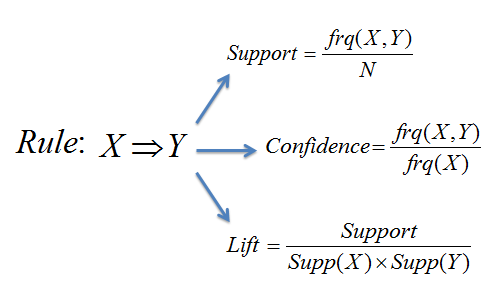

In [ ]:
# product association decisions results
rule_fp_associ = association_rules(rule_fp, metric = "confidence", min_threshold=0.4) 
rule_fp_associ.sort_values("confidence",ascending=False).head()

## For example: (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...)	(GREEN REGENCY TEACUP AND SAUCER)	
- antecedents: percentage of presence in all products: 0.023527	
- consequent: percentage of presence in all products: 0.037287	
If we make an evaluation for these two products;
- Percentages of coexistence in all products: 0.021045	 (support) //  Support = Freq(A,B)/N
- The probability of these two products being together: 0.894495 (confidence) // Confidence = Freq(A,B)/Freq(A)
- Percentage of product consequents in products containing product antecedents: (0.021045)/(0.023527*0.037287) = 23.989564	  (lift)

In [ ]:
# products that are found together in 40 percent and more
apriori_items = apriori(basket, min_support=0.02, use_colnames=True)
rule_apriori = association_rules(apriori_items, metric = "confidence", min_threshold=0.4) 
rule_apriori.sort_values("confidence",ascending=False).head()

In [ ]:
rule_fp_associ.to_csv("/content/drive/MyDrive/RFM/datas/rule_fp_associ.csv", index = False)
rule_apriori.to_csv("/content/drive/MyDrive/RFM/datas/rule_apriori.csv", index = False)

# COHORT ANALYSIS

In [ ]:
def get_month(x):
  return dt.datetime(x.year, x.month, 1)
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.head()

In [ ]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [ ]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [ ]:
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.head()

In [ ]:
df.tail()

In [ ]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [ ]:
cohort_counts

**Retention Rate**

In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(2) * 100

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
annot = True,
fmt = '.0%',
vmin = 0.0,
vmax = 0.5,
cmap = 'GnBu')
plt.show()